<a href="https://colab.research.google.com/github/Pinky-Chaudhary/py/blob/master/DMBI_DesicionTree%2CNavie_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from itertools import combinations,permutations,chain
import numpy as np
 
class Apriori:
    def __init__(self,df,df1,min_sup,min_conf):
        self.df = df
        self.df1 = df1
        self.min_sup = min_sup
        self.min_conf = min_conf
        self.item_set = df1.columns
        
    def getRules(self):
        rules=[]
        for i in range(1,len(self.item_set)+1):
            rules.append(list(combinations(self.item_set,i)))  
        print(rules)
        return rules
    
    def getFrequentItemSet(self):
        fequent_itemset=dict()
        rules = self.getRules()
        for i in self.item_set:
            if self.df1[i].mean() >= self.min_sup:
                fequent_itemset[i]=round(self.df1[i].mean(),2)
        for rule in rules:
            for i in rule:
                result = [True for i in range(len(self.item_set)+1)]
                for j in range(0,len(i)):
                    result = np.logical_and(result,self.df[i[j]])
                if result.mean() >=self.min_sup:
                    fequent_itemset[i] = round(result.mean(),2)
        print(fequent_itemset)
        return fequent_itemset         
        
    def getRulesWithMinConfidence(self):
        frequent_itemset = self.getFrequentItemSet()
        L = tuple(list(frequent_itemset.keys())[-1])
        subset = map(tuple,sorted(chain(*[combinations(L,i+1) for i,a in enumerate(L)])))
        Confidence_set =[]
        for i in subset:
            remain = set(L).difference(set(i))
            if(len(remain) > 0):
                confidence = round(frequent_itemset[L]/frequent_itemset[i],2)
                if confidence >= self.min_conf:
                    Confidence_set.append([list(i),list(remain),confidence])
 
        return Confidence_set
 
 
 
def main():
    print("----------------Apriori Algorithm----------------")
    min_sup = float(input("Enter Minimum Support: "))
    min_conf = float(input("Enter Minimum Confidence: "))
    filepath = input("Enter File Path: ")
    df = pd.read_csv(filepath)
    df1 = df['Transaction'].str.get_dummies(sep=',')
    df[df1.columns] = df1
    print(df1)
    a = Apriori(df,df1,min_sup,min_conf)
    Confidence_Set = a.getRulesWithMinConfidence()
    print("Anticident=>Consequent      Confidence")
    for i,j,conf in Confidence_Set:
        
        print(i,"=>",j,"       ",conf)
main()

----------------Apriori Algorithm----------------


In [ ]:
# /content/APRIORI1.CSV
"C:\\Users\\ADMIN\\OneDrive\\pinky\\sem7\\DMBI\\APRIORI1.CSV")

In [ ]:
training_data = [
           ['Positive','Low','High','Up'],
           ['Negative','High','Low','Down'],
           ['Positive','Low','High','Up'],
           ['Positive','High','High','Up'],
           ['Negative','Low','High','Down'],
           ['Positive','Low','Low','Down'],
           ['Negative','High','High','Down'],
           ['Negative','Low','High','Down'],
           ['Positive','Low','Low','Down'],
           ['Positive','High','High','Up'],
]
header = ['PAST_TREND','OPEN_INTREST','TRADING_VALUE','RETURN']


In [ ]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

class Question:
    """A Question is used to partition a dataset.
    This class just records a 'column number' and a 'column value'.
    """
    def __init__(self, column, value):
        self.column = column
        self.value = value
    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (header[self.column], condition, str(self.value))

def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

def gini(rows):
    """Calculate the Gini Impurity for a list of rows. """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

def info_gain(left, right, current_uncertainty):
    """Information Gain.
    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

def find_best_split(rows):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

class Leaf:
    """A Leaf node classifies data. """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

class Decision_Node:
    """A Decision Node asks a question.
    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,question,true_branch,false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

def build_tree(rows):
    """Builds the tree.

    Rules of recursion: 1) Believe that it works. 2) Start by checking
    for the base case (no further information gain). 3) Prepare for
    giant stack traces.
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Decision_Node(question, true_branch, false_branch)

def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

DecisionTree = build_tree(training_data)

In [ ]:
print_tree(DecisionTree)

In [ ]:
def classify(row, node):
    """See the 'rules of recursion' above."""
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions
    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [ ]:
testing_data = ['Negative','High','High']
print_leaf(classify(testing_data, DecisionTree))

{'Down': '100%'}

In [ ]:
# Make Predictions with Naive Bayes On The Iris Dataset
from csv import reader
from math import sqrt
from math import exp
from math import pi

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
		print('[%s] => %d' % (value, i))
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split the dataset by class values, returns a dictionary
def separate_by_class(dataset):
	separated = dict()
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1]
		if (class_value not in separated):
			separated[class_value] = list()
		separated[class_value].append(vector)
	return separated

# Calculate the mean of a list of numbers
def mean(numbers):
	return sum(numbers)/float(len(numbers))

# Calculate the standard deviation of a list of numbers
def stdev(numbers):
	avg = mean(numbers)
	variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
	return sqrt(variance)

# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
	summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(summaries[-1])
	return summaries

# Split dataset by class then calculate statistics for each row
def summarize_by_class(dataset):
	separated = separate_by_class(dataset)
	summaries = dict()
	for class_value, rows in separated.items():
		summaries[class_value] = summarize_dataset(rows)
	return summaries

# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
	exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
	return (1 / (sqrt(2 * pi) * stdev)) * exponent

# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
	total_rows = sum([summaries[label][0][2] for label in summaries])
	probabilities = dict()
	for class_value, class_summaries in summaries.items():
		probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
		for i in range(len(class_summaries)):
			mean, stdev, _ = class_summaries[i]
			probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
	return probabilities

# Predict the class for a given row
def predict(summaries, row):
	probabilities = calculate_class_probabilities(summaries, row)
	best_label, best_prob = None, -1
	for class_value, probability in probabilities.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
	return best_label

# Make a prediction with Naive Bayes on Iris Dataset
filename = filenames
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# fit model
model = summarize_by_class(dataset)
# define a new record
row = [5.7,2.9,4.2,1.3]
# predict the label
label = predict(model, row)
print('Data=%s, Predicted: %s' % (row, label))

FileNotFoundError: ignored

In [ ]:
filenames= 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv'

In [ ]:
import pandas as pd

training_data =[
                ['sunny','hot','high','FALSE','no'],
                ['sunny','hot','high','TRUE','no'],
                ['overcast','hot','high','FALSE','yes'],
              
                ['rainy','mild','high','FALSE','yes'],
                ['rainy','cool','normal','FALSE','yes'],
                ['rainy','cool','normal','TRUE','no'],
                ['overcast','cool','normal','TRUE','yes'],
                ['sunny','mild','high','FALSE','no'],
                ['sunny','cool','normal','FALSE','yes'],
                ['rainy','mild','normal','FALSE','yes'],
                ['sunny','mild','normal','TRUE','yes'],
                ['overcast','mild','high','TRUE','yes'],
                ['overcast','hot','normal','FALSE','yes'],
                ['rainy','mild','high','TRUE','no']
]
header = ['outlook','temperature','humidity','windy','play']
data = pd.DataFrame(training_data,columns=header)

In [ ]:
data

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,FALSE,no
1,sunny,hot,high,TRUE,no
2,overcast,hot,high,FALSE,yes
3,rainy,mild,high,FALSE,yes
4,rainy,cool,normal,FALSE,yes
5,rainy,cool,normal,TRUE,no
6,overcast,cool,normal,TRUE,yes
7,sunny,mild,high,FALSE,no
8,sunny,cool,normal,FALSE,yes
9,rainy,mild,normal,FALSE,yes


In [ ]:

Classes ={}
target = data.columns[-1]
labels = data[target].unique()
for i in data.columns[:-1]:
  Columns = {}
  for j in data[i].unique():
    Probabilty = {}
    for label in labels:
      Probabilty[label] = round(data[i][data[i]==j].where(data[target] == label).count()/data[target].where(data[target] == label).count(),2)
    Columns[j] = Probabilty
  Classes[i] = Columns
Classes


{'humidity': {'high': {'no': 0.8, 'yes': 0.33},
  'normal': {'no': 0.2, 'yes': 0.67}},
 'outlook': {'overcast': {'no': 0.0, 'yes': 0.44},
  'rainy': {'no': 0.4, 'yes': 0.33},
  'sunny': {'no': 0.6, 'yes': 0.22}},
 'temperature': {'cool': {'no': 0.2, 'yes': 0.33},
  'hot': {'no': 0.4, 'yes': 0.22},
  'mild': {'no': 0.4, 'yes': 0.44}},
 'windy': {'FALSE': {'no': 0.4, 'yes': 0.67},
  'TRUE': {'no': 0.6, 'yes': 0.33}}}

In [ ]:
for i in Classes.keys():
  print("========================="+i+"==============================")
  print(pd.DataFrame.from_dict({j: Classes[i][j]
                           for j in Classes[i].keys()},
                       orient='index'))

=========================outlook==============================
           no   yes
sunny     0.6  0.22
overcast  0.0  0.44
rainy     0.4  0.33
=========================temperature==============================
       no   yes
hot   0.4  0.22
mild  0.4  0.44
cool  0.2  0.33
=========================humidity==============================
         no   yes
high    0.8  0.33
normal  0.2  0.67
=========================windy==============================
        no   yes
FALSE  0.4  0.67
TRUE   0.6  0.33


In [ ]:
Target = {}
for label in labels:
  Target[label] = data[target][data[target] == label].count()/data[target].count()

In [ ]:
Target


{'no': 0.35714285714285715, 'yes': 0.6428571428571429}

In [ ]:
today = ('sunny', 'hot','normal','FALSE')
Prob = {}
for label in labels:
  result=1
  for i,j in zip(today,data.columns[:-1]):
    result *= Classes[j][i][label]
  Prob[label] = round(result*Target[label],4)
print(Prob)
max(Prob)

{'no': 0.0069, 'yes': 0.014}


'yes'

In [ ]:
import pandas as pd
training_data =[
                ['sunny','hot','high','false','no'],
                ['sunny','hot','high','true','no'],
                ['overcast','hot','high','false','yes'],
                ['rainy','mild','high','false','yes'],
                ['rainy','cool','normal','false','yes'],
                ['rainy','cool','normal','true','no'],
                ['overcast','cool','normal','true','yes'],
                ['sunny','mild','high','false','no'],
                ['sunny','cool','normal','false','yes'],
                ['rainy','mild','normal','false','yes'],
                ['sunny','mild','normal','true','yes'],
                ['overcast','mild','high','true','yes'],
                ['overcast','hot','normal','false','yes'],
                ['rainy','mild','high','true','no']]
header = ['outlook','temperature','humidity','windy','play']

class NaiveBayes:
  def __init__(self,Data):
    self.data = Data
    self.target = self.data.columns[-1]
    # self.columns = self.data.columns[:-1]
    self.labels = self.data[self.target].unique()
    self.Classes = dict()
    self.Target = dict()

  def PostereirProbability(self):

    """ 
        This Function Generates the Probability Table of Each Column with refrence to Target value P(B|A)
        P(Bi|Ai) = count(Bi){where Ai is known}/count(Ai)
    """

    for column in self.data.columns[:-1]:
      cols=dict()
      for col_unique in self.data[column].unique():
        probabilty_value = dict()
        for label in self.labels:
          count = self.data[column][self.data[column]==col_unique].where(self.data[self.target] == label).count()
          probabilty_value[label] = round(count/self.data[self.target].where(self.data[self.target] == label).count(),4)
        cols[col_unique] = probabilty_value
      self.Classes[column] = cols

  def displayProbability(self):
    """ 
        This Function Display the Probability Table of Each Column with refrence to Target value
        P(B|A)
    """
    self.PostereirProbability()
    print("Probability values for all the classes with respect to Target Labels:")
    for i in self.Classes.keys():
      print("========================="+i.upper()+"=========================")
      print(pd.DataFrame.from_dict({j: self.Classes[i][j] for j in self.Classes[i].keys()},orient='index'))

  def getTarget(self):
    """ 
        This Function Generates the Probability values of Individual Target Variable
        ex : P(A1) = count(A1)/SUM(count(A1),count(A2),...,count(An))
    """
    self.displayProbability()
    for label in self.labels:
      self.Target[label] = round(self.data[self.target][self.data[self.target] == label].count()/self.data[self.target].count(),4)
    print("=========================Probability Of the Target Values=========================\nP(A):",self.Target)


  def prediction(self,Value):
    """
        This Function Predict the Taget class for Given Value by calculating P(A|B)
        P(A|B) = P(B|A)*P(A)
        INPUT: dict()
        Output = Maximum(P(A1|B),P(A2|B),...,P(An|B))
    """

    self.getTarget()
    probability_target = dict()
    for label in self.labels:
      result = 1
      for i,j in Value.items():
        result *= self.Classes[i][j][label]
      probability_target[label] = result*self.Target[label]
    #To convert this into a probability by making the sum equal to 1 (normalization)

    summation = sum(probability_target.values())
    res = {key:round(value/summation,2) for key,value in probability_target.items()}
    maximum = max(res, key=res.get) #key of maximum value
    return (maximum,max(res.values()))

def main():
    print("=========================Naive Bayes Classifier=========================")
    df = pd.DataFrame(training_data,columns=header)
    Values={}
    print("Enter the Parameter to predict the Class Label")
    for i in df.columns[:-1]:
      print("{} : from {}: ".format(i,df[i].unique()))
      Values[i] =input()
 
    naive_Bayes = NaiveBayes(df)
    output,Probability = naive_Bayes.prediction(Values)
    print("========================Output from Calssifier========================")
    print("\nPridicted Class Label for given input parameter '{}' and  P(A|B): {} ".format(output,Probability))
main()


=========================Naive Bayes Classifier=========================
Enter the Parameter to predict the Class Label
outlook : from ['sunny' 'overcast' 'rainy']: 
rainy
temperature : from ['hot' 'mild' 'cool']: 
cool
humidity : from ['high' 'normal']: 
high
windy : from ['false' 'true']: 
true
Probability values for all the classes with respect to Target Labels:
=========================OUTLOOK=========================
           no     yes
sunny     0.6  0.2222
overcast  0.0  0.4444
rainy     0.4  0.3333
=========================TEMPERATURE=========================
       no     yes
hot   0.4  0.2222
mild  0.4  0.4444
cool  0.2  0.3333
=========================HUMIDITY=========================
         no     yes
high    0.8  0.3333
normal  0.2  0.6667
=========================WINDY=========================
        no     yes
false  0.4  0.6667
true   0.6  0.3333
=========================Probability Of the Target Values=========================
P(A): {'no': 0.3571, 'yes': 0.6429}
=

In [ ]:
 # #      Implement data smoothing techniques CO2
 
# Smoothing by bin means : In smoothing by bin means, each value in a bin is replaced by the mean value of the bin.
# Smoothing by bin median : In this method each bin value is replaced by its bin median value.
# Smoothing by bin boundary : In smoothing by bin boundaries, the minimum and maximum values in a given bin are identified as the bin boundaries. Each bin value is then replaced by the closest boundary value.
 
# Sort the array of given data set.
# Divides the range into N intervals, each containing the approximately same number of samples(Equal-depth partitioning).
# Store mean/ median/ boundaries in each row.
import statistics
class Smoothing:
  def __init__(self,Array,bin):
    self.data = Array
    self.bin_size = bin
    self.Bins = []
  def initial_steps(self):
    self.data = sorted(self.data)
    for i in range(0,len(self.data),self.bin_size):
      self.Bins.append(self.data[i:i+self.bin_size])
    print(self.Bins)
 
  def bin_mean(self):
    print("Smoothing By Bin Mean")
    for i in range(len(self.Bins)):
      mean = sum(self.Bins[i])//self.bin_size
      self.Bins[i] = [mean for i in range(self.bin_size)]
    print([i for j in self.Bins for i in j])
 
  def bin_median(self):
    print("Smoothing By Bin Median")
    for i in range(len(self.Bins)):
      median = statistics.median(self.Bins[i])
      self.Bins[i] = [median for i in range(self.bin_size)]
    print([i for j in self.Bins for i in j])
 
  def bin_boundary(self):
    print("Smoothing By Bin Boundary ")
    Binz = []
    for i in self.Bins:
      res = [i[0]] #for Lower Boundary value in bin
      for j in range(1,len(i)-1):
        if i[j]-i[0] <= i[-1]-i[j]:
          res.append(i[0])
        else:
            res.append(i[-1])
      res.append(i[-1])
      Binz.append(res)
    print([i for j in Binz for i in j])
 
def main():
    print("-----------Smoothing Techniques---------")
    print("Enter Array to be smoothed ")
    Array = list(map(int,input().split(",")))
    bin = int(input("Enter Bin size: "))
    S = Smoothing(Array,bin)
    S.initial_steps()
    print("Select a Smoothing method \n1.Bin_mean\n2.Bin_Median\n3.Bin_Boundary")
    choice = int(input())
    if choice == 1:
      S.bin_mean()
    elif choice == 2:
      S.bin_median()
    elif choice == 3:
      S.bin_boundary()
    else:
      print("Incorrect Choice")
 
main()

-----------Smoothing Techniques---------
Enter Array to be smoothed 
4,8,9,15,21,21,24,25,26,28,29,34
Enter Bin size: 3
[[4, 8, 9], [15, 21, 21], [24, 25, 26], [28, 29, 34]]
Select a Smoothing method 
1.Bin_mean
2.Bin_Median
3.Bin_Boundary
3
Smoothing By Bin Boundary 
[4, 9, 9, 15, 21, 21, 24, 24, 26, 28, 28, 34]


In [ ]:
 
import statistics as s
class Normalization:
    def __init__(self,Array):
        self.data= Array
    def minMax(self):
        print("Original Min:{} Original Max:{}".format(min(self.data),max(self.data)))
        Min_max = [(i-min(self.data))/(max(self.data)-min(self.data)) for i in self.data]
        return Min_max
    def zScore(self):
        ZScore= [round((i- s.mean(self.data))/s.pstdev(self.data),3) for i in self.data]
        return ZScore
 
 
def main():
    print("Enter Data to be Normalized")
    data= list(map(int,input().split()))
    print("Data:",data)
    norm= Normalization(data)
    print("----------------Min-Max Normalization------------")
    print(norm.minMax())
    print("------------------ZScore Normalization-------------")
    print(norm.zScore())
 
main()

Enter Data to be Normalized
200 300 400 600 1000
Data: [200, 300, 400, 600, 1000]
----------------Min-Max Normalization------------
Original Min:200 Original Max:1000
[0.0, 0.125, 0.25, 0.5, 1.0]
------------------ZScore Normalization-------------
[-1.061, -0.707, -0.354, 0.354, 1.768]


In [ ]:
# To study about Data mining and Data Warehousing         CO2
#    Create a pivot table and pivot chart on sample database in excel CO2
#    Implement data smoothing techniques CO2
#    Implement normalization techniques CO2
#    To study about data mining tool: Weka CO1
#    Implement APRIORI algorithm in Weka CO1
#    Implement APRIORI Algorithm in JAVA CO1
#    Implement Decision Tree classification in Weka CO1 
#    Implement Decision Tree Classification in .Net/Python/Java CO1
#    Implement Naïve  bayes algorithm in Weka CO1
#    Implement Naïve  bayes Classification in .Net/Python/Java CO1
#    Implement k-mean clustering algorithm CO1
 
#    3 binning technique
#    4 min max and z2 method
 
#    first page title page collegename,subjectname,rollno,
#    2nd page certificate
#    3rd page index srno title page remarks
#    from 4th page all the practicals
# word and pdf file both updation

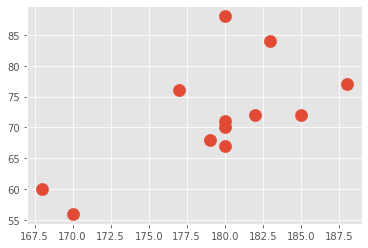

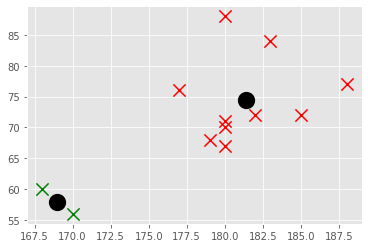

In [ ]:
 
samples = [[185,72],[170,56],[168,60],[179,68],[182,72],[188,77],[180,71],[180,70],[183,84],[180,88],[180,67],[177,76]]
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
style.use('ggplot')
X = np.array(samples)
 
plt.scatter(X[:,0], X[:,1], s=150)
plt.show()
 
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
 
    def fit(self,data):
 
        self.centroids = {}
 
        for i in range(self.k):
            self.centroids[i] = data[i]
 
        for i in range(self.max_iter):
            self.classifications = {}
 
            for i in range(self.k):
                self.classifications[i] = []
 
            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
 
            prev_centroids = dict(self.centroids)
 
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)
 
            optimized = True
 
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100):
                    optimized = False
 
            if optimized:
                break
 
    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification
model = K_Means(k=2,max_iter=1)
model.fit(X)
 
for centroid in model.centroids:
    plt.scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)
colors =['r','g','b']
for classification in model.classifications:
    color= colors[classification]
    for featureset in model.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)
        
plt.show()